In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
from math import sqrt, log, exp
from scipy.stats import norm
import random

## Question 1

$$\mathop{argmin}\limits_{w}\dfrac{1}{2}w'\Sigma w \qquad  s.t. \quad w' \textbf{1} = 1, \qquad \mu_{\Pi}=w'\mu=m$$
$L(w, \lambda, \gamma)=\dfrac{1}{2}w'\Sigma w+\lambda(m-w'\mu)+\gamma(1-w'\textbf{1})\\
\dfrac{\partial L}{\partial w}=\Sigma w-\lambda\mu-\gamma \textbf{1}\\
\dfrac{\partial L}{\partial \lambda}=m-w'\mu\\
\dfrac{\partial L}{\partial \gamma}=1-w'\textbf{1}$

Optimal weight vector $w^{*}$ is

$w^*=\dfrac{1}{AC - B^{2}}\Sigma^{-1}[(A\mu - B\textbf{1})m+(C\textbf{1}-B\mu)],$

where

$
A=\textbf{1}' \Sigma ^{-1} \textbf{1} \\
B=\textbf{1}' \Sigma ^{-1} \mu \\
C=\mu' \Sigma^{-1} \mu
$

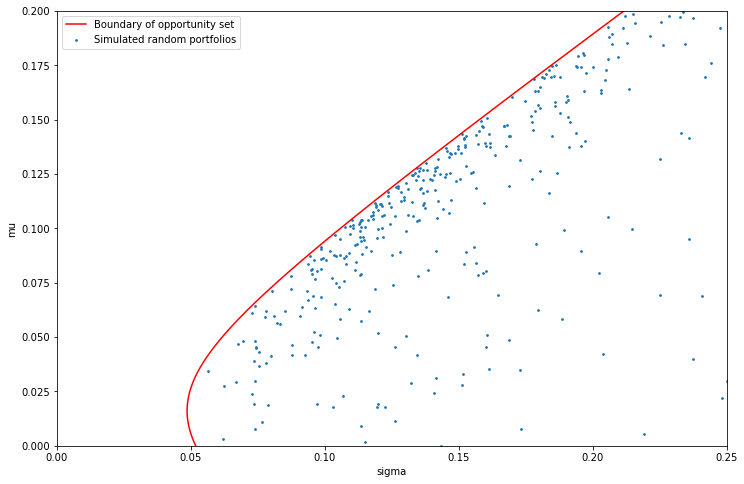

In [2]:
#Inputs
mu = np.array([
        [0.02], 
        [0.07], 
        [0.15], 
        [0.2],
    ])

sigma = np.array([
        [0.05], 
        [0.12], 
        [0.17], 
        [0.25],
    ])

rho = np.array([   
        [1, 0.3, 0.3, 0.3], 
        [0.3, 1, 0.6, 0.6], 
        [0.3, 0.6, 1, 0.6], 
        [0.3, 0.6, 0.6, 1]
    ])

#Scalars for analytical solutions
cov = np.diag(sigma.flatten()) @ rho @ np.diag(sigma.flatten())
I = np.ones(len(mu)).reshape(len(mu), 1)
inv_cov = np.linalg.inv(cov)
A = I.T @ inv_cov @ I
B = I.T @ inv_cov @ mu
C = mu.T @ inv_cov @ mu

#Simulations of unoptimal portfolios
numofportfolio = 700
np.random.seed()
simulation = 2 * np.random.random(size=(len(mu), numofportfolio)) - 1
simulation = simulation/simulation.sum(axis=0)
sim_vol = []
sim_ret = []
for i in range(simulation.shape[1]):
    weights = simulation[:,i].reshape(len(simulation[:,0]),1)
    sim_vol.append(sqrt(weights.T @ cov @ weights))
    sim_ret.append(float(weights.T @ mu))
    
#Analytical solution for opportunity set boundary
target_rets = np.linspace(0, 1, 1000)
tvols = []
for tr in target_rets:
    ef_omega = (1 / (A * C - B ** 2)) * inv_cov @ ((A * mu - B * I) * tr + (C * I - B * mu))
    ef_vol = float(np.sqrt(ef_omega.T @ cov @ ef_omega))
    tvols.append(ef_vol)
    
#Plot of simulated portfolios vs analytical boundary
plt.figure(figsize=(12, 8))
plt.xlabel('sigma')
plt.ylabel('mu')

plt.scatter(sim_vol, sim_ret, s=3, label='Simulated random portfolios')
plt.plot(tvols, target_rets, color='red', label='Boundary of opportunity set')

plt.xlim(0, 0.25)
plt.ylim(0, 0.2)
plt.legend(loc='upper left', frameon=True)
plt.show()

Blue dots indicate randomly simulated portfolios' risk/return. They all lie inside analytially calculated hyperbola which serves as a boundary of the opportunity set. 

## Question 2

$$\mathop{argmax}\limits_{w}\dfrac{w' \mu - r}{(w'\Sigma w)^{1/2}}\qquad  s.t. \quad w' \textbf{1} = 1$$
$L(w, \lambda)=\dfrac{w' \mu - r}{(w'\Sigma w)^{1/2}}+\lambda(w'\textbf{1}-1) \\ $

$\dfrac{\partial L}{\partial w}= \mu(w'\Sigma w)^{-1/2}-(w' \mu - r)(w'\Sigma w)^{-3/2}\Sigma w + \lambda \textbf{1}\\
\dfrac{\partial L}{\partial \lambda}=w'\textbf{1}-1$

   Optimisation problem above doesn't look too friendly to solve but we can utilise the result from the lecture arguing that tangency portfolio is effectively a solution of two easier optimisations.

In [3]:
#Tangency portfolios calculations for various risk-free rates
tangency_table = pd.DataFrame(columns=['Risk-free rate', 'Mu', 'Sigma', 'Weights'])
for r in [0.005, 0.01, 0.015, 0.0175]:
    tangency_p = (1 / (B - A * r)) * inv_cov @ (mu - r * I)
    tangency_vol = float(np.sqrt(tangency_p.T @ cov @ tangency_p))
    tangency_mu = float(tangency_p.T @ mu)
    tangency_table = tangency_table.append({'Risk-free rate' : r, 'Mu' : tangency_mu, 'Sigma' : tangency_vol,
                                           'Weights' : tangency_p.flatten()}, ignore_index = True)
np.set_printoptions(precision=4)
tangency_table.style.format('{:.4f}', subset=['Mu', 'Sigma']).format('{:.2%}', subset=['Risk-free rate']).hide_index()

Risk-free rate,Mu,Sigma,Weights
0.50%,0.1861,0.1965,[ 0.0168 -0.2294 0.8143 0.3982]
1.00%,0.3261,0.3507,[-0.7459 -0.5106 1.4902 0.7663]
1.50%,1.7765,1.9724,[-8.6449 -3.4226 8.4897 4.5778]
1.75%,-1.2988,1.4735,[ 8.1035 2.7519 -6.3514 -3.5039]


   Results generally confirm the intuition. When the risk-free rate is low (relatively to risky asset returns), tangency portfolio provides low risk/low return. As price of leverage is low, even if market participants have big appetite for risk, it is rational for them to borrow at risk-free to purchase this conservative portfolio with leverage. 
   
   However, as the price of leverage rises (level of risk-free rate), tangency portfolio becomes higher risk/higher return. In this case risk averse market participants adhere to only small allocation to this risky portfolio and to keeping rest of their capital in risk-free asset, which is more attractive than in the first case. 
    
   Finally, there is a third case, eg 175bps in our example. The risk-free rate is high, and so is the oppurtunity cost of allocating positive capital to any portfolio of risky assets. But if we are allowed to short risky portfolio, with some combinations of weights we can generate positive expected return and also additional cash to invest into very attractive risk-free asset. Mathematically this means that tangency point is on the lower wing of hyperbola (which in other cases is of no interest to us) as in our example with 175bps. Still, there is oppurtunity to produce return above risk-free rate via negative allocation to tangency portfolio.

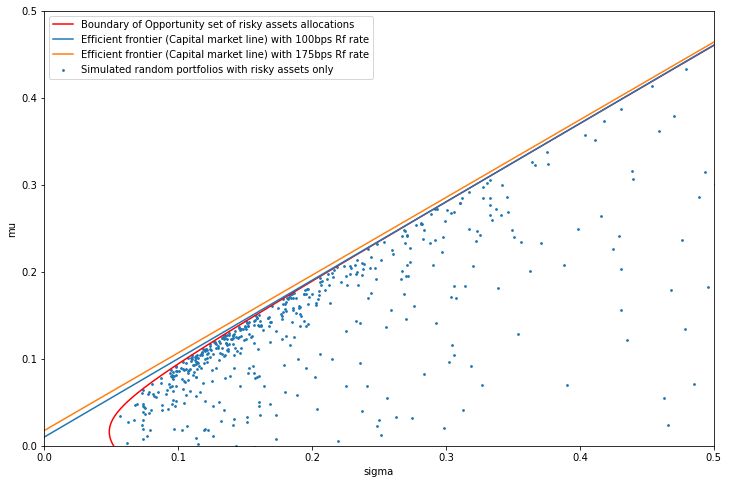

In [4]:
r = 0.01
comp_vol_100 = []
comp_ret_100 = np.linspace(r, 1, 1000)
for m in comp_ret_100:
    omega_r = (m - r) * inv_cov @ (mu - r * I) / ((mu - r * I).T @ inv_cov @ (mu - r * I))
    vol_r = float(np.sqrt(omega_r.T @ cov @ omega_r))
    comp_vol_100.append(vol_r)
r = 0.0175
comp_vol_175 = []
comp_ret_175 = np.linspace(r, 1, 1000)
for m in comp_ret_175:
    omega_r = (m - r) * inv_cov @ (mu - r * I) / ((mu - r * I).T @ inv_cov @ (mu - r * I))
    vol_r = float(np.sqrt(omega_r.T @ cov @ omega_r))
    comp_vol_175.append(vol_r)
    
plt.figure(figsize=(12, 8))
plt.xlabel('sigma')
plt.ylabel('mu')

plt.scatter(sim_vol, sim_ret, s=3, label='Simulated random portfolios with risky assets only')
plt.plot(tvols, target_rets, color='red', label='Boundary of Opportunity set of risky assets allocations')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.plot(comp_vol_100, comp_ret_100, label='Efficient frontier (Capital market line) with 100bps Rf rate')
plt.plot(comp_vol_175, comp_ret_175, label='Efficient frontier (Capital market line) with 175bps Rf rate')
plt.legend(loc='upper left', frameon=True)
plt.show()

   Efficient frontiers for both risk-free rates are positvely sloped half-lines. Portfolios on negatively sloped half-lines are also attainable via linear conbinations of risk-free asset and tangency portfolio. However, these portfolios cannot belong to a true efficient frontier since they are strongly dominated by 100% allocation to a risk-free asset. 

## Question 3

In [5]:
def call_option_binomial(S, K, T, r, sigma, N):
    dt = T / N
    #Paul's parametrisation
    #u = 1 + sigma * sqrt(dt)
    #v = 1 - sigma * sqrt(dt)
    
    #Hull's parametrisation
    u = exp(sigma * sqrt(dt))
    v = exp(-sigma * sqrt(dt))
    
    p = (exp(r * dt) - v) / (u - v)
    d = exp(-r * dt)
    V = np.zeros([N + 1, N + 1])
    for i in range(N + 1):
        spot = S * (v ** i) * (u ** (N - i))
        V[i, N] = max(spot - K, 0)
    for j in range(N, 0, -1):
        for i in range(j):
            V[i, j - 1] = d * ( p * V[i, j] + (1 - p) * V[i + 1, j])
    return V[0, 0]

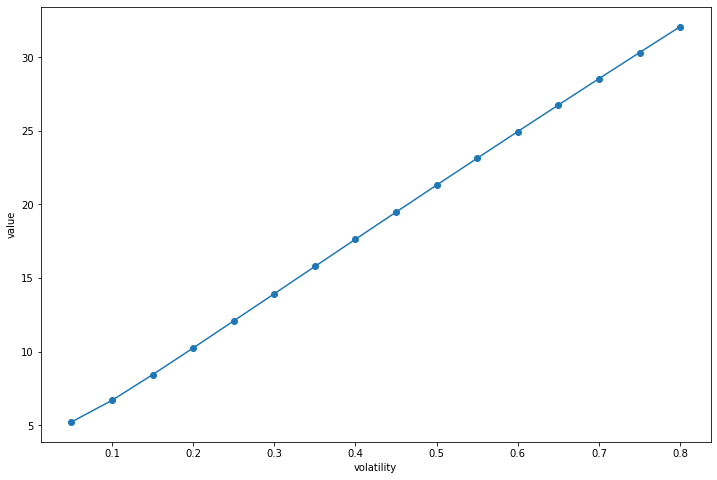

In [6]:
vol_vector = np.linspace(0.05, 0.8, 16)
values_vector = []
for v in vol_vector:
    values_vector.append(call_option_binomial(100, 100, 1, 0.05, v, 10))

plt.figure(figsize=(12, 8))
plt.xlabel('volatility')
plt.ylabel('value')
plt.plot(vol_vector, values_vector, 'o-')
plt.show()

   Option value rises as the volatility of underlying asset rises. 

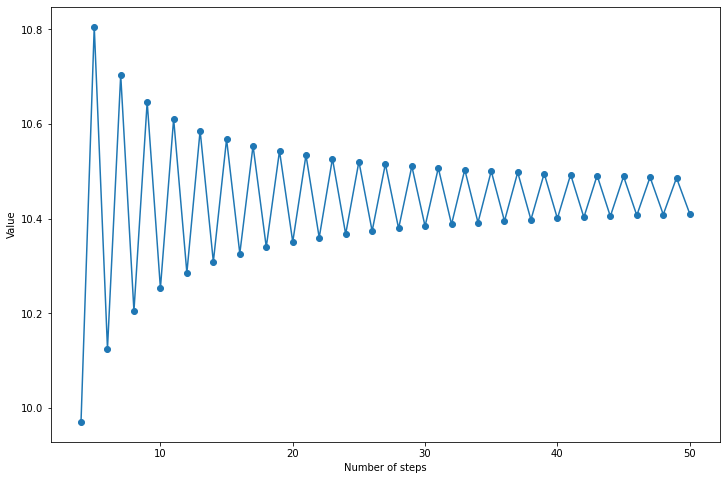

In [7]:
NTS = range(4,51,1)
values_vector = []
for N in NTS:
    values_vector.append(call_option_binomial(100, 100, 1, 0.05, 0.2, N))
    
plt.figure(figsize=(12, 8))
plt.xlabel('Number of steps')
plt.ylabel('Value')
plt.plot(NTS, values_vector, 'o-')
plt.show()

   Visually, the value of the option converges to some number as the number of steps increases. On the infinity it should be Black-Scholes value.

## Question 4

In [8]:
def expected_shortfall_sn(x):
    return -norm.pdf(norm.ppf(x))/x

In [9]:
percentiles = [99.95, 99.75, 99.5, 99.25, 99, 98.5, 98, 97.5]
es = []
for p in percentiles:
    x = 1 - p / 100
    es.append(expected_shortfall_sn(x))
es_df = pd.DataFrame({'Percentile':percentiles, 'Expected Shortfall for N(0,1)':es})
es_df.style.format('{:.2f}').hide_index()

Percentile,"Expected Shortfall for N(0,1)"
99.95,-3.55
99.75,-3.10
99.50,-2.89
99.25,-2.76
99.00,-2.67
98.50,-2.52
98.00,-2.42
97.50,-2.34


## Question 5

In [10]:
filename = 'Data_SP500.csv'
input_data = pd.read_csv(filename, index_col=[0], parse_dates=True, dayfirst=True)
factor = norm.ppf(0.01)
calc_df = input_data.copy()
calc_df['Log Returns'] = np.log(calc_df['SP500']).diff()
calc_df['Rolling std dev'] = calc_df['Log Returns'].rolling(21).std()
calc_df['VaR'] = calc_df['Rolling std dev'] * factor * sqrt(10)
#calculating forward reslised 10D returns avoiding overlap for a more conservative backtest
calc_df['Following 10D Return'] = np.log(calc_df['SP500'].shift(-11)) - np.log(calc_df['SP500'].shift(-1))
calc_df['VaR Breach'] = np.where(calc_df['Following 10D Return'] < calc_df['VaR'], 1, 0)
calc_df['VaR consecutive Breach'] = calc_df['VaR Breach'] * calc_df['VaR Breach'].shift(1)
print("Number of Breaches is", calc_df['VaR Breach'].sum())
print("Precentage of Breaches is", '{:.2%}'.format(calc_df['VaR Breach'].sum()/
                                                  len(calc_df[['VaR', 'Following 10D Return']].dropna())))
print("Number of Consecutive Breaches is", '{:.0f}'.format(calc_df['VaR consecutive Breach'].sum()))
print("Precentage of Consecutive Breaches is", 
      '{:.2%}'.format(calc_df['VaR consecutive Breach'].sum()/
                     (calc_df['VaR Breach'].sum() - 1)))

Number of Breaches is 25
Precentage of Breaches is 2.05%
Number of Consecutive Breaches is 14
Precentage of Consecutive Breaches is 58.33%


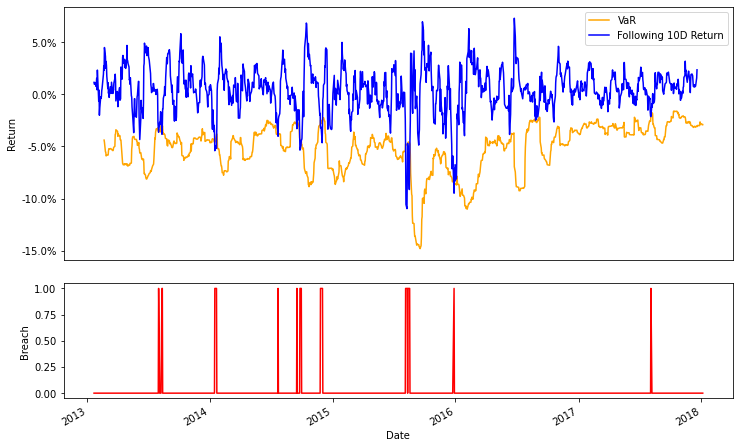

In [11]:
fig = plt.figure(figsize = (12,8))
gs = fig.add_gridspec(nrows=3, ncols=1)
ax = fig.add_subplot(gs[:-1])
ax2 = fig.add_subplot(gs[-1], sharex=ax)
ax.get_xaxis().set_visible(False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
sns.lineplot(data=calc_df.reset_index(), x="Date", y='VaR', ax=ax, color='orange')
sns.lineplot(data=calc_df.reset_index(), x="Date", y='Following 10D Return', ax=ax, color='blue')
sns.lineplot(data=calc_df.reset_index(), x="Date", y='VaR Breach', ax=ax2, color='red')
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax2.set_ylabel("Breach")
ax.legend(labels=['VaR', 'Following 10D Return', 'Breach'])
fig.autofmt_xdate()
plt.show()

   Analytical parametric VaR doesn't perform too well in a backtest. Increasing the rolling window in some way may help but will not change the fact that some assumtions (normality for example) may not agree well with the data. To confirm it, we may want to consult with qq plot or run statistical test on returns data.

## Question 6

In [13]:
llambda = 0.72
calc_df['Squared Log Returns'] = calc_df['Log Returns'] ** 2
#snooping ahead here initial sigma^2 but not criminal in practice
calc_df['EWMA Variance'].iloc[0] = calc_df['Log Returns'].std() ** 2
#we will calcualte column EWMA Variance for date t as an estimate on day t for the date t+1 (sigma^2_{t+1|t})
#that makes indexing slightly different comparing with the tutorial but it shouldn't affect the outcome
for i in range(1, len(calc_df), 1):
        calc_df['EWMA Variance'].iloc[i] = \
        llambda * calc_df['EWMA Variance'].iloc[i-1] + (1 - llambda) * calc_df['Squared Log Returns'].iloc[i]
calc_df['EWMA VaR'] = np.sqrt(calc_df['EWMA Variance']) * factor * sqrt(10)
calc_df['EWMA VaR Breach'] = np.where(calc_df['Following 10D Return'] < calc_df['EWMA VaR'], 1, 0)
calc_df['EWMA VaR consecutive Breach'] = calc_df['EWMA VaR Breach'] * calc_df['EWMA VaR Breach'].shift(1)
print("Number of Breaches is", calc_df['EWMA VaR Breach'].sum())
print("Precentage of Breaches is", '{:.2%}'.format(calc_df['EWMA VaR Breach'].sum()/
                                                   len(calc_df[['EWMA VaR', 'Following 10D Return']].dropna())))
print("Number of Consecutive Breaches is", '{:.0f}'.format(calc_df['EWMA VaR consecutive Breach'].sum()))
print("Precentage of Consecutive Breaches is", 
      '{:.2%}'.format(calc_df['EWMA VaR consecutive Breach'].sum()/
                     (calc_df['EWMA VaR Breach'].sum() - 1)))

Number of Breaches is 32
Precentage of Breaches is 2.58%
Number of Consecutive Breaches is 17
Precentage of Consecutive Breaches is 54.84%


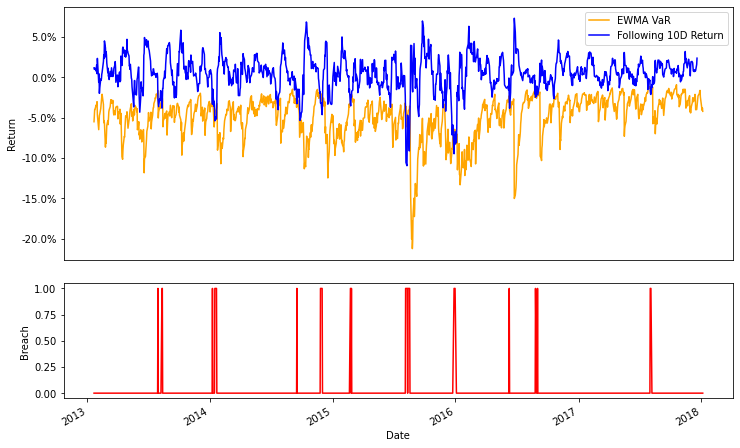

In [14]:
fig = plt.figure(figsize = (12,8))
gs = fig.add_gridspec(nrows=3, ncols=1)
ax = fig.add_subplot(gs[:-1])
ax2 = fig.add_subplot(gs[-1], sharex=ax)
ax.get_xaxis().set_visible(False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
sns.lineplot(data=calc_df.reset_index(), x="Date", y='EWMA VaR', ax=ax, color='orange')
sns.lineplot(data=calc_df.reset_index(), x="Date", y='Following 10D Return', ax=ax, color='blue')
sns.lineplot(data=calc_df.reset_index(), x="Date", y='EWMA VaR Breach', ax=ax2, color='red')
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax2.set_ylabel("Breach")
ax.legend(labels=['EWMA VaR', 'Following 10D Return', 'Breach'])
fig.autofmt_xdate()
plt.show()

   EWMA forecast in this case is also not too successful. We may try to tweak lambda parameter or alternatively try other method.